In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import jupyros as jr
import rospy
from nav_msgs.msg import Odometry
import ipywidgets as widgets
from move_base_msgs.msg import MoveBaseActionFeedback
from move_base_msgs.msg import MoveBaseActionGoal
from geometry_msgs.msg import Twist
from jupyros import ros3d
from sensor_msgs.msg import LaserScan
from actionlib_msgs.msg import GoalID
from actionlib_msgs.msg import GoalStatusArray
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox
import ipywidgets as widgets
import os
from IPython.display import clear_output
import time
import termios
from ipywidgets import TwoByTwoLayout
from matplotlib.animation import FuncAnimation
from std_msgs.msg import Int32

In [2]:
pub_movebase = rospy.Publisher("move_base/goal", MoveBaseActionGoal, queue_size = 50)
pub_cancel = rospy.Publisher("move_base/cancel", GoalID, queue_size = 50)
pub_vel = rospy.Publisher("cmd_vel", Twist, queue_size = 50)
rospy.init_node('final_assignment')

In [3]:
id = 0
def goToPose(b):
    global id
    msg = MoveBaseActionGoal()
    msg.goal.target_pose.header.frame_id = "map"
    msg.goal.target_pose.pose.orientation.w = 1
    done = 0
    dist_thresh = 0.3
    msg.goal.target_pose.pose.position.x = x_goal.value
    msg.goal.target_pose.pose.position.y = y_goal.value
    # Move to the desired x and y
    pub_movebase.publish(msg)
    status = None
    while status is None:
            status = rospy.wait_for_message("move_base/status", GoalStatusArray)
    # Retrieve the id of the goal
    id = status.status_list[-1].goal_id.id
    print("The robot starts moving")
    t0 = rospy.Time.now().to_sec()
    while (now - t0) < 60:
        now = rospy.Time.now().to_sec()
        while status is None:
            status = rospy.wait_for_message("move_base/status", GoalStatusArray)
        if (state == 1):
            reached_goals.append(1)
            break
    if state != 1:
        reached_goals.append(0)
def cancelPose(b):
    global id
    msg_cancel = GoalID()
    msg_cancel.id = id
    pub_cancel.publish(msg_cancel)
    
def first_choice(pointless=None):
    """ Function to autonomously reach the desired x,y coordinate. Corresponds to the first choise of UI.

    Args:
        None

    Returns:
        int: **1** if done

    .. note::
        The completion of the goal position is checked via calculating the Euclidean distance between the goal and the
        actual position. The threshold is set to 0.3, but can be changed to be more accurate.
    """
    # Constructing our message to sent to the /move_base topic
    clear_output(wait=True)
    print("The first option has been chosen, now please insert x and y coordinate")
    
    start = Button(description = "Start", layout=Layout(height='auto', width='auto'))
    start.on_click(goToPose)
    cancel = Button(description = "Cancel", layout=Layout(height='auto', width='auto'))
    cancel.on_click(cancelPose)
    exit = Button(description = "Exit", layout=Layout(height='auto', width='auto'))
    exit.on_click(on_button_clicked_e)
    display(x_goal, y_goal, start, cancel, exit)

In [4]:
msgTwist = Twist()
msgTwist.linear.y = 0
msgTwist.linear.z = 0
msgTwist.angular.x = 0
msgTwist.angular.y = 0
done = 0
safeDistance = 0.3
def on_button_clicked_w(b):
    global msgTwist
    msgTwist.linear.x = 0.5
    msgTwist.angular.z = 0
    if helping:
        laser = rospy.wait_for_message("/scan", LaserScan)
        data = laser.ranges
        # So, now we are calculating the minimal distance and not allowing the user to go crush
        [minLeft, minFront, minRight] = calculateMinDistance(data)
        if minFront < safeDistance:
            if msgTwist.linear.x > 0:
                print("Sorry, but you cannot move to the front, because there is an obstacle\n")
                msgTwist.linear.x = 0
    move(msgTwist)
def on_button_clicked_s(b):
    global msgTwist
    msgTwist.linear.x = -0.5
    msgTwist.angular.z = 0
    move(msgTwist)
def on_button_clicked_a(b):
    global msgTwist
    msgTwist.linear.x = 0
    msgTwist.angular.z = 2
    if helping:
        laser = rospy.wait_for_message("/scan", LaserScan)
        data = laser.ranges
        # So, now we are calculating the minimal distance and not allowing the user to go crush
        [minLeft, minFront, minRight] = calculateMinDistance(data)
        if minRight < safeDistance:
            if msgTwist.angular.z > 0:
                print("Sorry, but you cannot move to the left, because there is an obstacle\n")
                msgTwist.angular.z = 0
    move(msgTwist)
def on_button_clicked_d(b):
    global msgTwist
    msgTwist.linear.x = 0
    msgTwist.angular.z = -2
    if helping:
        laser = rospy.wait_for_message("/scan", LaserScan)
        data = laser.ranges
        # So, now we are calculating the minimal distance and not allowing the user to go crush
        [minLeft, minFront, minRight] = calculateMinDistance(data)
        if minLeft < safeDistance:
            if msgTwist.angular.z < 0:
                print("Sorry, but you cannot move to the right, because there is an obstacle\n")
                msgTwist.angular.z = 0
    move(msgTwist)
def on_button_clicked_e(b):
    my_print()       

def move(msg):
    pub_vel.publish(msg)
    time.sleep(0.2)
    msg.linear.x = 0
    msg.angular.z = 0
    # Reset the velocity, so its like in real life, the user has to constantly
    # push the button to move forward for example. Not only once
    pub_vel.publish(msg)
    

In [5]:
def calculateMinDistance(data):
    """ Function to calculate the minimal distance
        from the robot to the obstacle, from the left side, right side and from frontal side

        Args:
            data (array of doubles): array of data from laser scan.

        Returns:
            (tuple): tuple containing:
                * **minDistanceLeft** (double): distance to the closest obstacle on the left

                * **minDistanceFront** (double): distance to the closest obstacle in front
                * **minDistanceRight** (double): distance to the closest obstacle on the right
    """
    minDistanceLeft = 30
    minDistanceFront = 30
    minDistanceRight = 30
    for i in range(0, 4*45):
        if data[i] < minDistanceLeft:
            minDistanceLeft = data[i]
    for i in range(4*45, 4*135):
        if data[i] < minDistanceFront:
            minDistanceFront = data[i]
    for i in range(4*135, len(data)):
        if data[i] < minDistanceRight:
            minDistanceRight = data[i]
    return minDistanceLeft, minDistanceFront, minDistanceRight

#
def third_choice(b):
    """ Function for manual control with assistance. It allows the user to drive the robot manually, but
        prevents it from crashing.

        Args:
            None

        Returns:
            int: **1** if done
    """
    global helping
    # Variable to set the minimal safe distance
    safeDistance = 0.5
    clear_output(wait=True)
    print("The third option has been chosen. Now you can manually control the robot, but the algorithm will help you not to crush into the walls. The list of keys are:")
    print("W or w: to move forward")
    print("S or s: to move backward")
    print("A or a: to turn left")
    print("D or d: to turn right")
    print("E or e: to exit the manual control\n\n")
    up = Button(description = 'FORWARD', layout = Layout(grid_area = 'b1'))
    left = Button(description = 'LEFT', layout = Layout(grid_area = 'b2'))
    right = Button(description = 'RIGHT', layout = Layout( grid_area = 'b3'))
    down = Button(description = 'BACKWARD', layout = Layout(grid_area = 'b4'))
    cancel = Button(description = 'Exit', layout = Layout(grid_area = 'b5'))
    driving_comm = GridBox(children = [up, left, right, down, cancel],layout = Layout(
        width = '50%', 
        grid_template_rows = 'auto auto',
        grid_template_columns='33% 33% 33% 33% 33%',
        grid_template_areas='''
        " . b1 . "
        "b2 . b3 "
        "b4 . b5 "
        ''')
    )
    helping = 1
    display(driving_comm)
    up.on_click(on_button_clicked_w)
    down.on_click(on_button_clicked_s)
    left.on_click(on_button_clicked_a)
    right.on_click(on_button_clicked_d)
    cancel.on_click(on_button_clicked_e)
    display_map()

In [6]:
class Visualiser:
    def __init__(self, limit_on_x, fig_title):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'bo')
        self.x_data, self.y_data = [], []
        self.x_limits = limit_on_x
        self.ax.set_title(fig_title)
        
    def plot_init(self):
        self.ax.set_xlim(-self.x_limits, self.x_limits)
        self.ax.set_ylim(-10, 10)
        return self.ln
    
    def odom_clbk(self, msg):
        self.y_data.append(msg.pose.pose.position.y) 
        self.x_data.append(msg.pose.pose.position.x)
       
    def laser_clbk(self, msg):
        self.x_data = msg.ranges
        self.y_data = msg.intensities        
   
    def refresh_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln
    
class Analysis:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.y_data = [0.05, 0.05] 
        self.labels = ['Reached', 'Non-Reached'] 
        self.bar = self.ax.bar(self.labels, self.y_data, color = 'b', width = 0.3)
        self.ax.set_ylim(top = 10)
        self.ax.set_title('Planning success history')
    
    def objective_clbk(self, msg):
        if msg.data == 1:
            self.y_data[0] += 1
        else :
            self.y_data[1] += 1
            
    def animate(self, frame):
        index = self.y_data[frame]
        self.bar[frame].set_height(index)
        
def display_map():
    # Visualize identical map of Gazebo to show robot's movement in real-time
    v = ros3d.Viewer()
    rc = ros3d.ROSConnection(url = "ws://localhost:9090")
    tf_client = ros3d.TFClient(ros = rc, fixed_frame = "map")

    laser_view = ros3d.LaserScan(topic = "/scan", ros = rc, tf_client = tf_client)
    map_view = ros3d.OccupancyGrid(topic = "/map", ros = rc, tf_client = tf_client, continuous = True)
    path = ros3d.Path(topic = "/move_base/NavfnROS/plan", ros = rc, tf_client = tf_client)
    urdf = ros3d.URDFModel(ros = rc, tf_client = tf_client, path = os.environ.get('JUPYROS_ASSETS_URL', "http://localhost:3000"))
    g = ros3d.GridModel()
    v.objects = [laser_view, map_view, urdf]
    display(v)

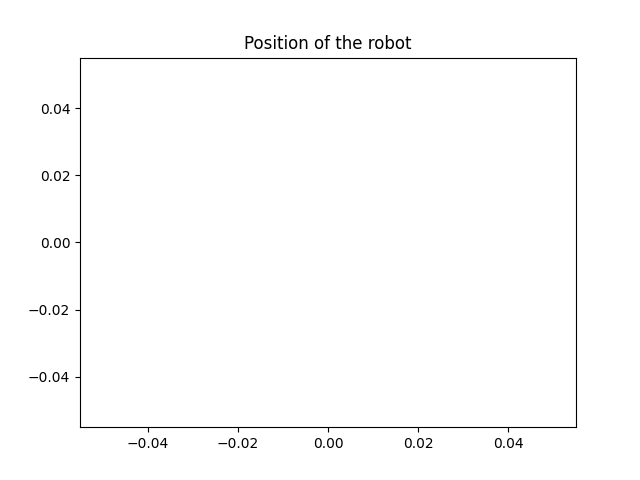

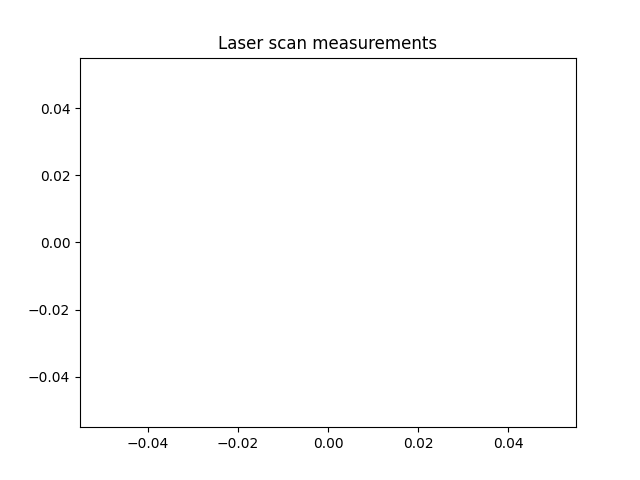

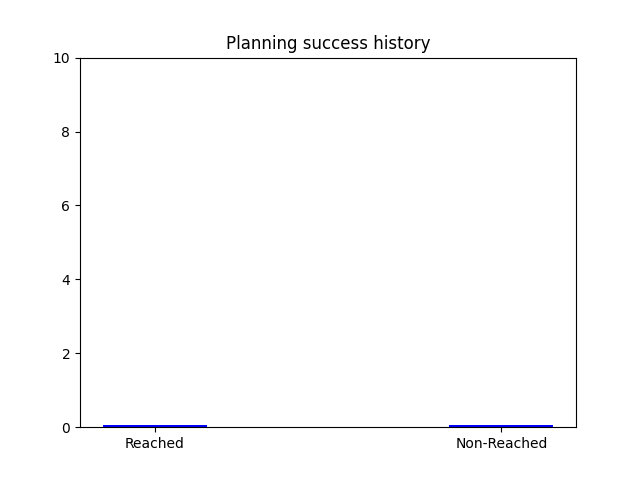

In [7]:
vis_odom = Visualiser(10, 'Position of the robot')
sub_odom = rospy.Subscriber('/odom', Odometry, vis_odom.odom_clbk)
ani1 = FuncAnimation(vis_odom.fig, vis_odom.refresh_plot, init_func = vis_odom.plot_init)
plt.show(block = True)

vis_scan = Visualiser(100, 'Laser scan measurements')
sub_scan = rospy.Subscriber('/scan', LaserScan, vis_scan.laser_clbk)
ani2 = FuncAnimation(vis_scan.fig, vis_scan.refresh_plot, init_func = vis_scan.plot_init)
plt.show(block = True)

analysis= Analysis()
sub_success = rospy.Subscriber('/goal_reached', Int32, analysis.objective_clbk)
ani3 = FuncAnimation(analysis.fig, analysis.animate, frames=2)
plt.show(block = True)

In [8]:
def second_choice(b):
    clear_output(wait=True)
    print("Well choice, Vin Diesel. Now you can manually control the robot. The list of keys are:")
    print("W or w: to move forward")
    print("S or s: to move backward")
    print("A or a: to turn left")
    print("D or d: to turn right")
    print("E or e: to exit the manual control\n\n")
    up = Button(description = 'FORWARD', layout = Layout(grid_area = 'b1'))
    left = Button(description = 'LEFT', layout = Layout(grid_area = 'b2'))
    right = Button(description = 'RIGHT', layout = Layout( grid_area = 'b3'))
    down = Button(description = 'BACKWARD', layout = Layout(grid_area = 'b4'))
    cancel = Button(description = 'Exit', layout = Layout(grid_area = 'b5'))
    driving_comm = GridBox(children = [up, left, right, down, cancel],layout = Layout(
        width = '50%', 
        grid_template_rows = 'auto auto',
        grid_template_columns='33% 33% 33% 33% 33%',
        grid_template_areas='''
        " . b1 . "
        "b2 . b3 "
        "b4 . b5 "
        ''')
    )
    display(driving_comm)
    helping = 0
    up.on_click(on_button_clicked_w)
    down.on_click(on_button_clicked_s)
    left.on_click(on_button_clicked_a)
    right.on_click(on_button_clicked_d)
    cancel.on_click(on_button_clicked_e)
    display_map()
    
def fourth_choice(b):
    exit(0)
    
def my_print():
    """ Function to simulate a UI to give the user a set of options

    Args:
        None

    Returns:
        None
    """
    clear_output(wait=True)
    print("Greetings! This is a UI for the mobile robot simulation, there are several options available, please choose one of them: ")
    print("1. Robot will autonomously reach the desired x and y coordinate")
    print("2. Manual control of the robot")
    print("3. Manual control of the robot with assistive mode")
    print("4. Exit the interface")
    first = Button(description="1", layout=Layout(height='auto', width='auto'))
    second = Button(description="2", layout=Layout(height='auto', width='auto'))
    third = Button(description="3", layout=Layout(height='auto', width='auto'))
    fourth = Button(description="4", layout=Layout(height='auto', width='auto'))
    layout2x2 = TwoByTwoLayout(top_left=first,
                   top_right=second,
                   bottom_left=third,
                   bottom_right=fourth)
    first.on_click(first_choice)
    second.on_click(second_choice)
    third.on_click(third_choice)
    fourth.on_click(fourth_choice)
    display(layout2x2)
    
helping = 0
reached_goals = []
x_goal = widgets.FloatText(description = "X coordinate: ")
y_goal = widgets.FloatText(description = "Y coordinate: ")
my_print()    

Greetings! This is a UI for the mobile robot simulation, there are several options available, please choose one of them: 
1. Robot will autonomously reach the desired x and y coordinate
2. Manual control of the robot
3. Manual control of the robot with assistive mode
4. Exit the interface


TwoByTwoLayout(children=(Button(description='1', layout=Layout(grid_area='top-left', height='auto', width='aut…